# USING DATASETS CREMA-D

In [11]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [12]:
path = 'D:/Datasets/CREMA-D/AudioWAV/'

In [13]:
crema_directory_list = os.listdir(path)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(path + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.head()

,Emotions,Path
0,angry,D:/Datasets/CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav
1,disgust,D:/Datasets/CREMA-D/AudioWAV/1001_DFA_DIS_XX.wav
2,fear,D:/Datasets/CREMA-D/AudioWAV/1001_DFA_FEA_XX.wav
3,happy,D:/Datasets/CREMA-D/AudioWAV/1001_DFA_HAP_XX.wav
4,neutral,D:/Datasets/CREMA-D/AudioWAV/1001_DFA_NEU_XX.wav


<Axes: xlabel='Emotions', ylabel='count'>

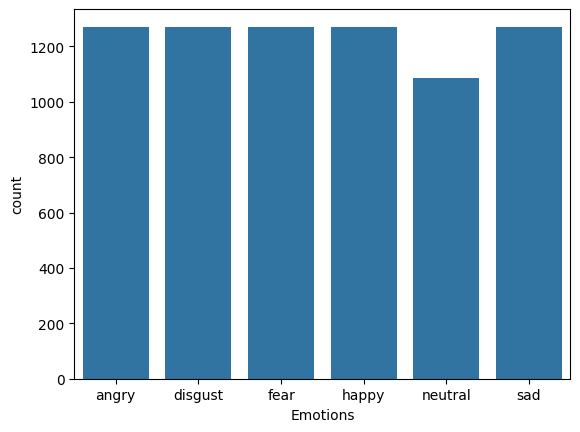

In [14]:
sns.countplot(data=df, x='Emotions')

In [15]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

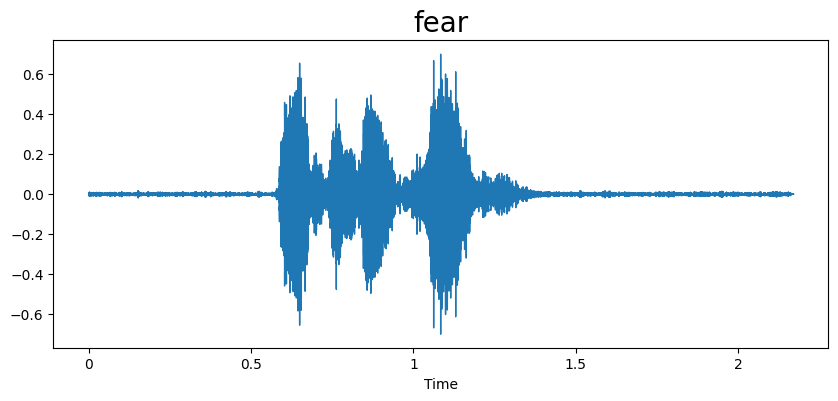

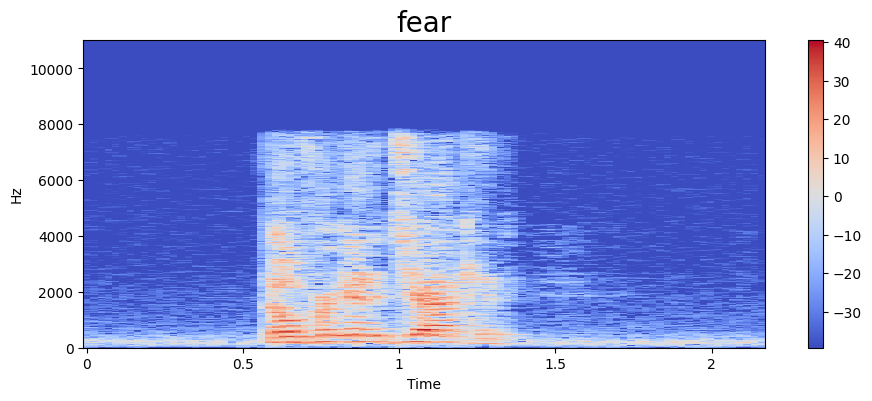

In [16]:
emotion = 'fear'
path = np.array(df['Path'][df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

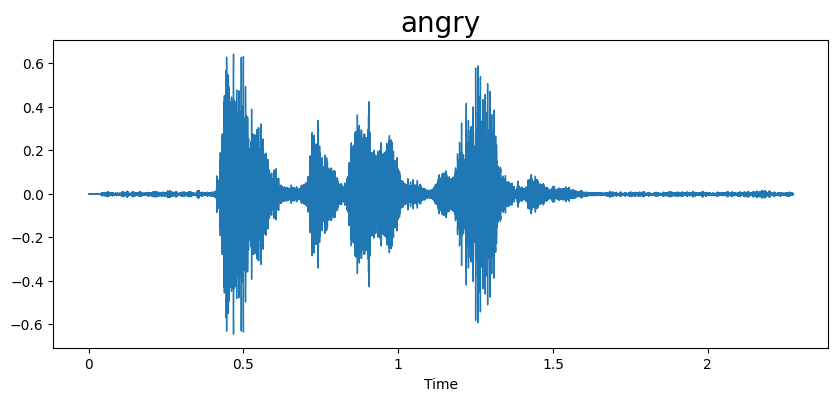

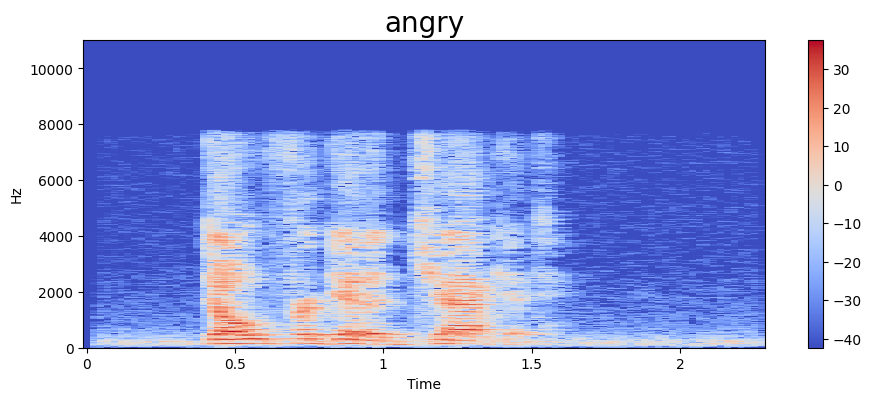

In [17]:
emotion = 'angry'
path = np.array(df['Path'][df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

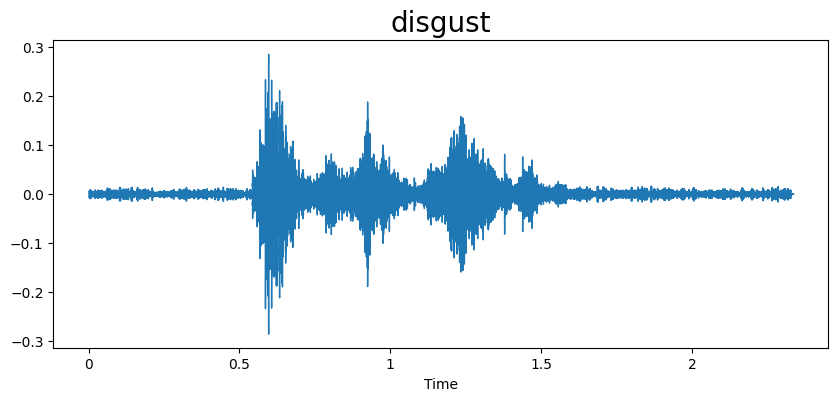

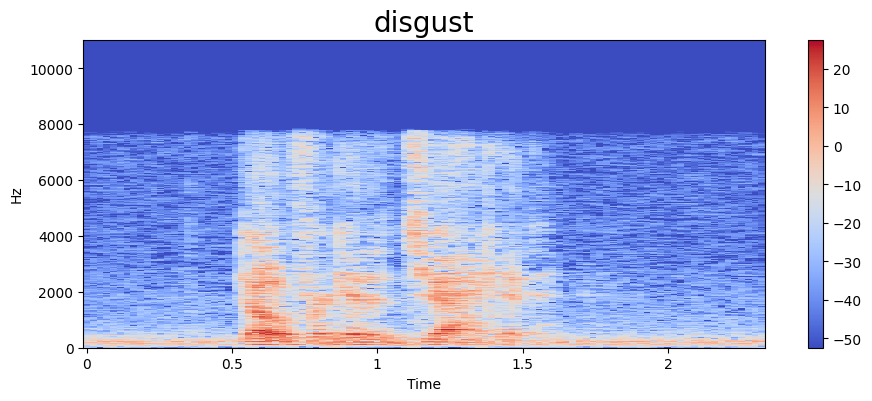

In [18]:
emotion = 'disgust'
path = np.array(df['Path'][df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

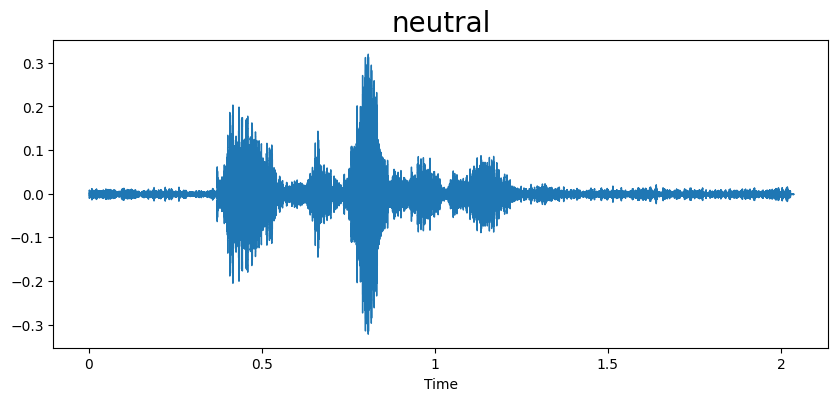

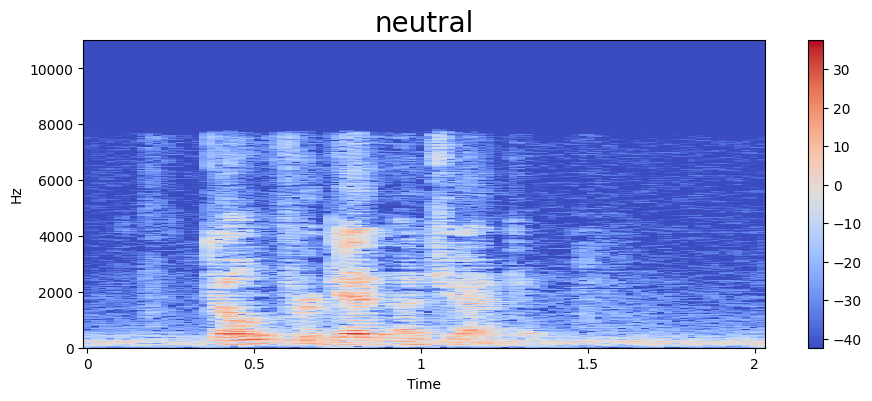

In [19]:
emotion = 'neutral'
path = np.array(df['Path'][df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

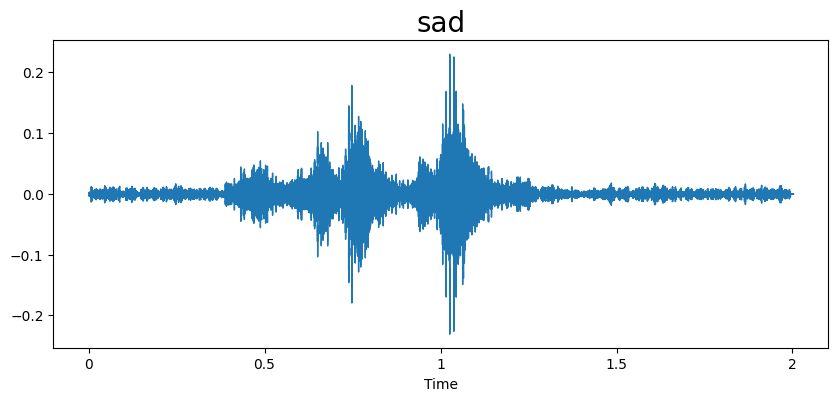

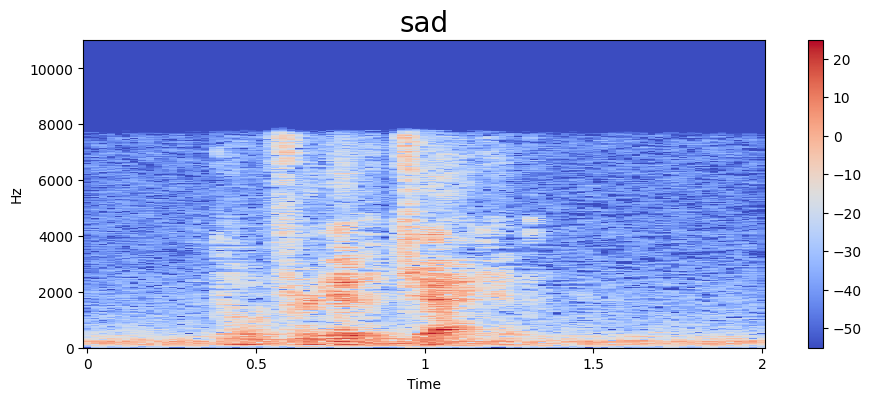

In [20]:
emotion = 'sad'
path = np.array(df['Path'][df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

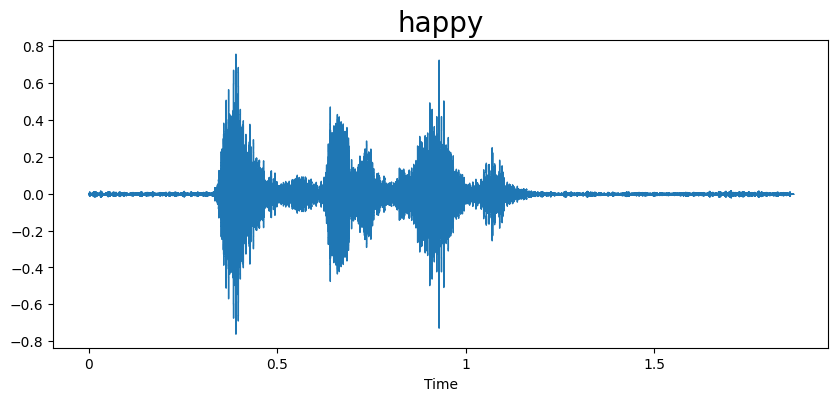

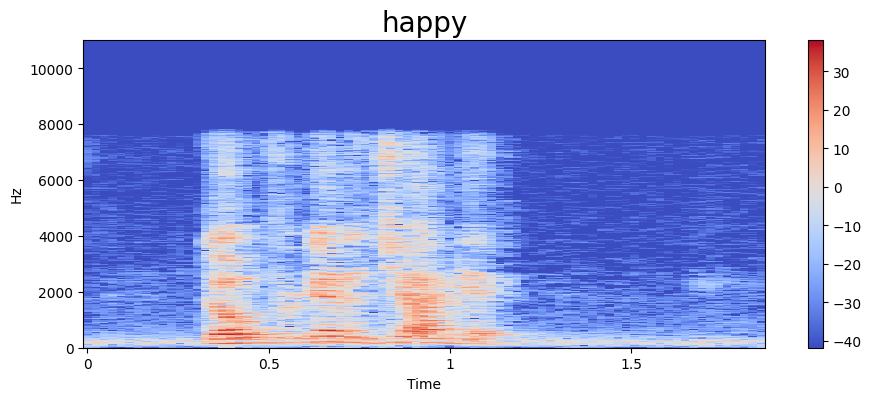

In [22]:
emotion = 'happy'
path = np.array(df['Path'][df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [24]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

<Figure size 1400x400 with 0 Axes>

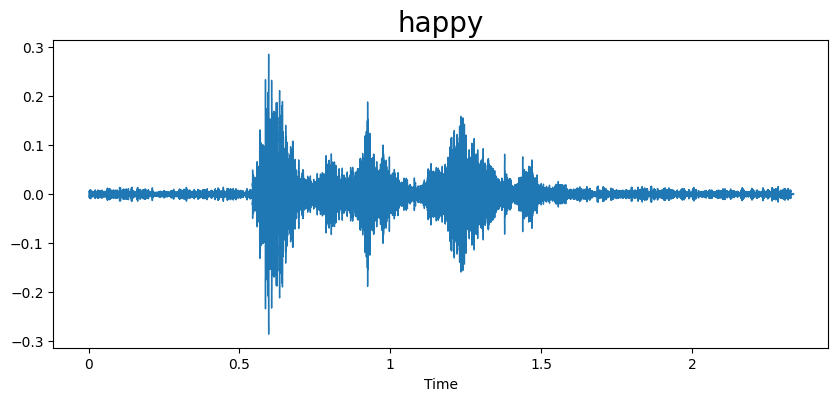

In [25]:
plt.figure(figsize=(14,4))
waveplot(data, sample_rate, emotion)
Audio(path)

<Figure size 1400x400 with 0 Axes>

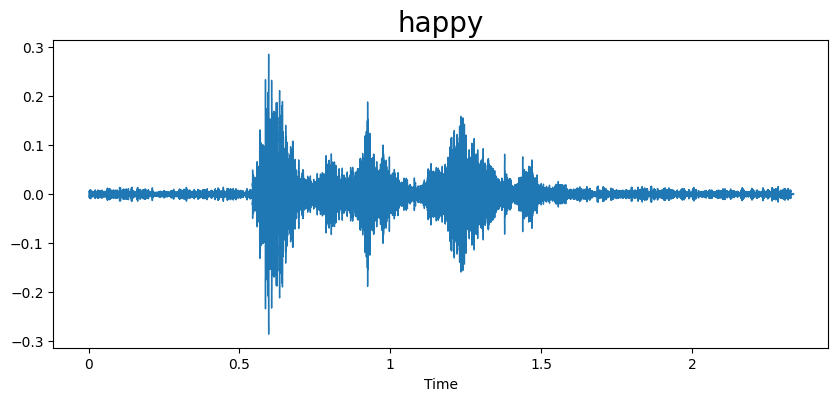

In [26]:
x = noise(data)
plt.figure(figsize=(14,4))
waveplot(data, sample_rate, emotion)
Audio(x, rate=sample_rate)

<Figure size 1400x400 with 0 Axes>

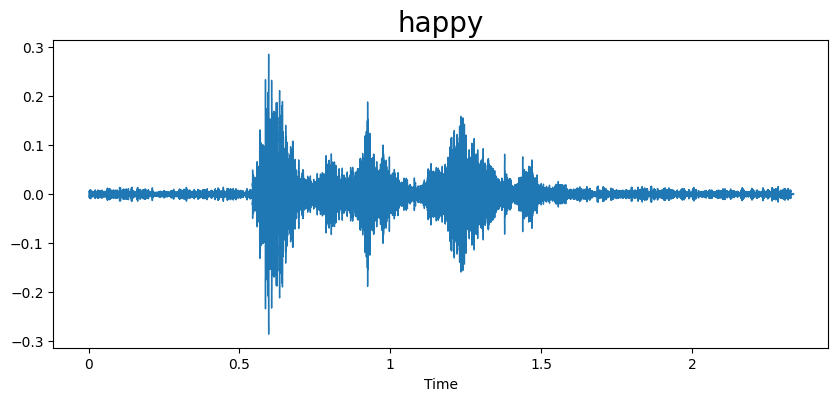

In [27]:
x = stretch(data)
plt.figure(figsize=(14,4))
waveplot(data, sample_rate, emotion)
Audio(x, rate=sample_rate)

<Figure size 1400x400 with 0 Axes>

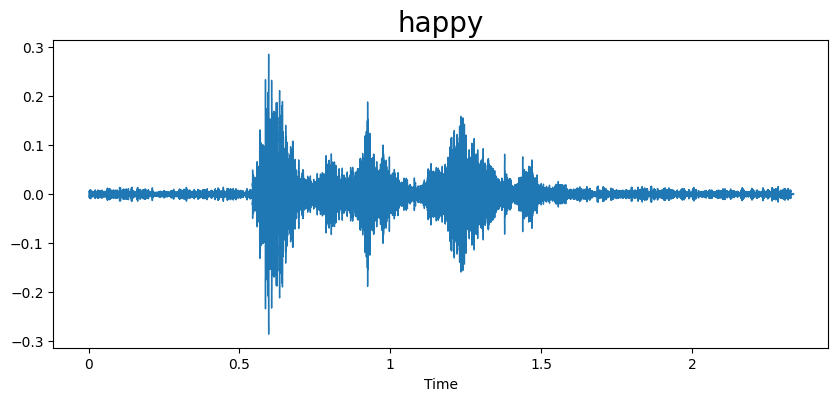

In [28]:
x = shift(data)
plt.figure(figsize=(14,4))
waveplot(data, sample_rate, emotion)
Audio(x, rate=sample_rate)

<Figure size 1400x400 with 0 Axes>

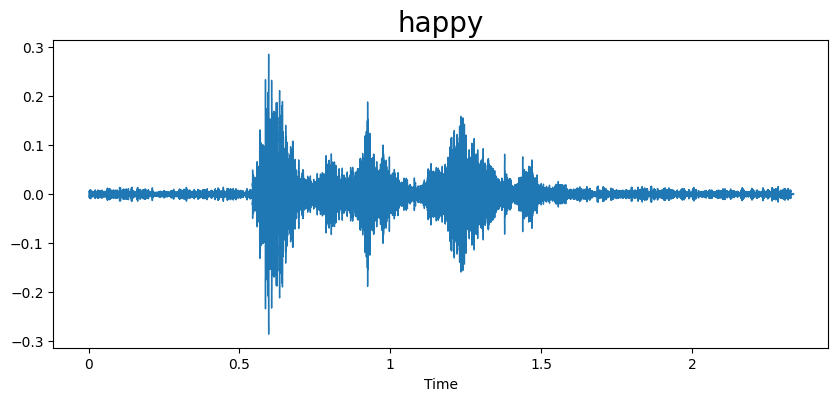

In [29]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
waveplot(data, sample_rate, emotion)
Audio(x, rate=sample_rate)

In [30]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [31]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [32]:
len(X), len(Y), df.Path.shape

(22326, 22326, (7442,))

In [33]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.085690,0.671934,0.694386,0.672386,0.675260,0.674322,0.579565,0.578604,0.647424,0.650719,...,6.261535e-08,5.799611e-08,5.473501e-08,5.232019e-08,5.053353e-08,4.925763e-08,4.833769e-08,4.774562e-08,4.738036e-08,angry
1,0.272093,0.779608,0.750159,0.760574,0.771352,0.819077,0.679389,0.611408,0.682407,0.687718,...,3.921652e-03,3.700114e-03,3.971184e-03,3.610785e-03,3.843376e-03,3.812307e-03,3.740695e-03,3.758998e-03,3.734966e-03,angry
2,0.093428,0.636517,0.615984,0.635542,0.683584,0.709475,0.584350,0.544492,0.627888,0.614113,...,5.421686e-08,4.762187e-08,4.319691e-08,3.999501e-08,3.765956e-08,3.605925e-08,3.509556e-08,2.803544e-08,1.090267e-08,angry
3,0.078444,0.718596,0.729192,0.653268,0.665332,0.687527,0.602966,0.577669,0.618406,0.681478,...,4.336244e-07,4.003988e-07,3.764672e-07,3.584461e-07,3.449016e-07,3.350527e-07,3.278495e-07,3.231356e-07,3.202182e-07,disgust
4,0.108932,0.762139,0.754992,0.700779,0.729358,0.719670,0.616208,0.590436,0.648509,0.707219,...,7.263611e-05,7.488415e-05,7.469900e-05,8.006139e-05,7.539416e-05,7.575592e-05,7.747256e-05,7.767653e-05,7.387490e-05,disgust


In [34]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [35]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [36]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162), (16744, 6), (5582, 162), (5582, 6))

In [37]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162), (16744, 6), (5582, 162), (5582, 6))

In [38]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162, 1), (16744, 6), (5582, 162, 1), (5582, 6))

In [41]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,222 (2.13 MB)

 Trainable params: 557,222 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.2873 - loss: 1.6653 - val_accuracy: 0.3664 - val_loss: 1.5116 - learning_rate: 0.0010
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.3539 - loss: 1.5298 - val_accuracy: 0.3766 - val_loss: 1.4894 - learning_rate: 0.0010
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.3712 - loss: 1.4935 - val_accuracy: 0.3746 - val_loss: 1.4848 - learning_rate: 0.0010
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.3807 - loss: 1.4740 - val_accuracy: 0.4079 - val_loss: 1.4451 - learning_rate: 0.0010
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.3905 - loss: 1.4619 - val_accuracy: 0.4128 - val_loss: 1.4187 - learning_rate: 0.0010
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.4008 - loss: 1.4270 - val_accuracy: 0.4185 - val_loss: 1.4115 - learning_rate: 0.0010
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.4137 - l

262/262 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.6335 - loss: 0.9277 - val_accuracy: 0.4826 - val_loss: 1.3410 - learning_rate: 0.0010
Epoch 45/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.6342 - loss: 0.9336 - val_accuracy: 0.4841 - val_loss: 1.4072 - learning_rate: 0.0010
Epoch 46/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.6366 - loss: 0.9198 - val_accuracy: 0.4857 - val_loss: 1.3559 - learning_rate: 0.0010
Epoch 47/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.6394 - loss: 0.9126 - val_accuracy: 0.4900 - val_loss: 1.4147 - learning_rate: 0.0010
Epoch 48/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.6499 - loss: 0.8887 - val_accuracy: 0.4936 - val_loss: 1.3779 - learning_rate: 0.0010
Epoch 49/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.6446 - loss: 0.9004 - val_accuracy: 0.4796 - val_loss: 1.3971 - learning_rate: 0.0010
Epoch 50/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.6532 - loss: 

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4866 - loss: 1.4180
Accuracy of our model on test data :  47.86814749240875 %


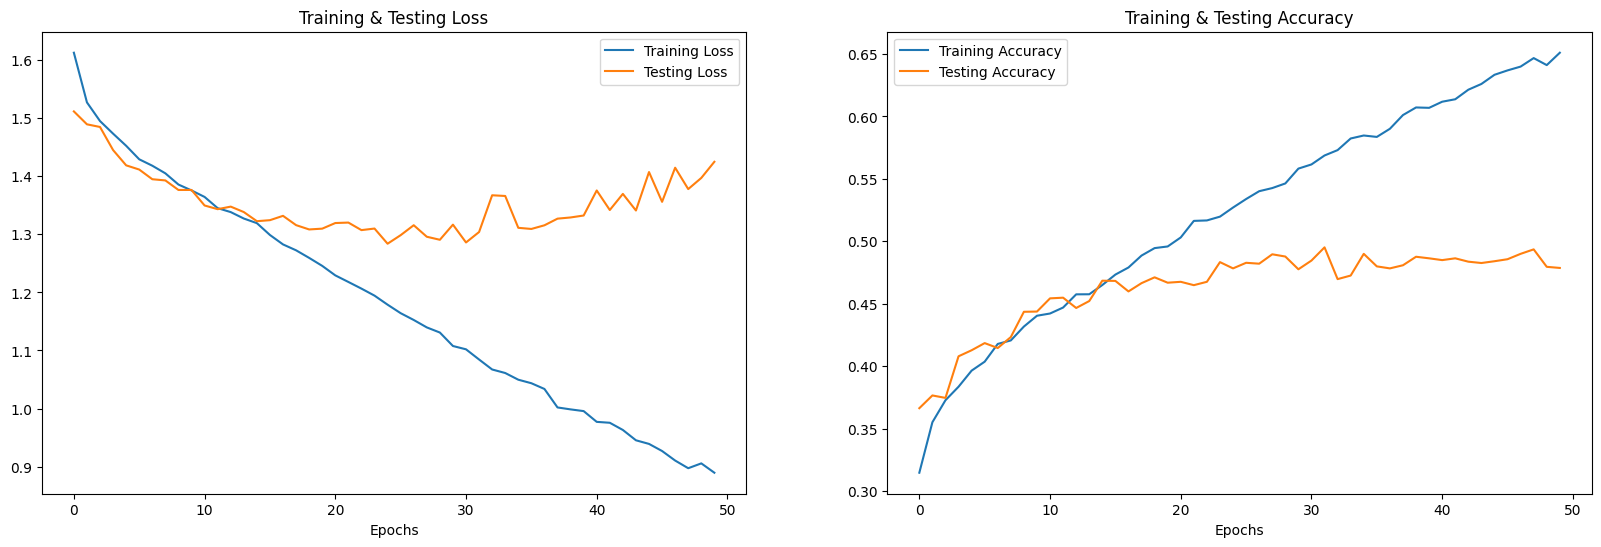

In [43]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [44]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [45]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,fear
1,angry,happy
2,sad,sad
3,neutral,neutral
4,sad,disgust
5,neutral,neutral
6,angry,angry
7,sad,sad
8,neutral,neutral
9,neutral,sad


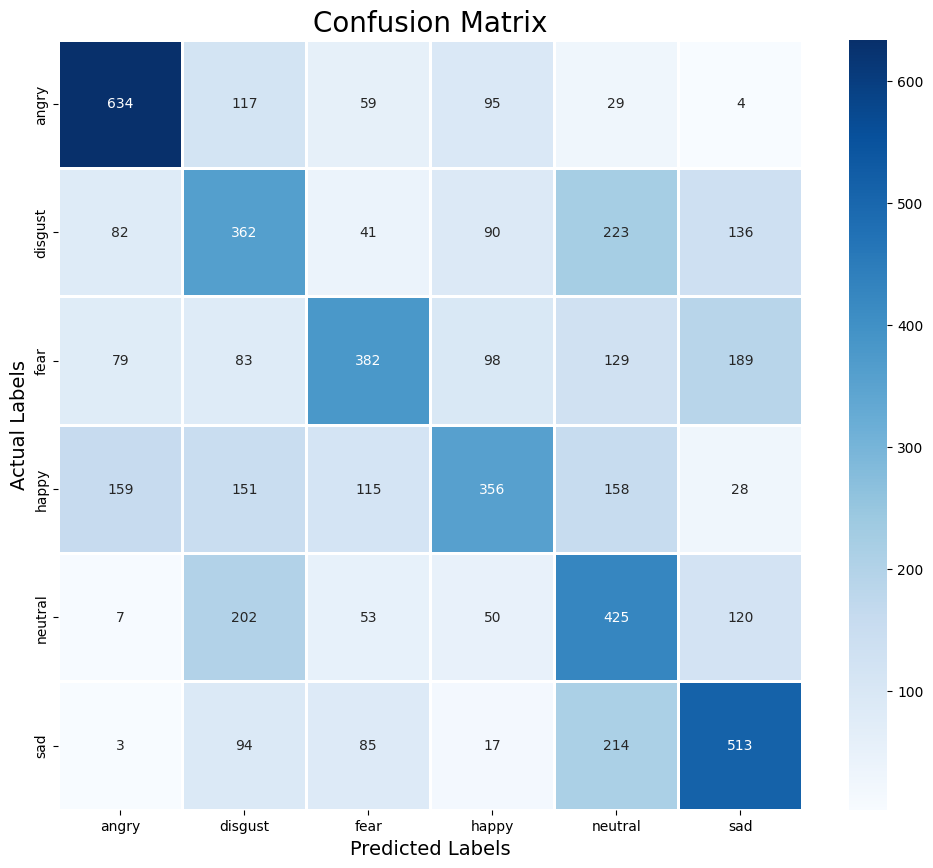

In [46]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.66      0.68      0.67       938
     disgust       0.36      0.39      0.37       934
        fear       0.52      0.40      0.45       960
       happy       0.50      0.37      0.43       967
     neutral       0.36      0.50      0.42       857
         sad       0.52      0.55      0.54       926

    accuracy                           0.48      5582
   macro avg       0.49      0.48      0.48      5582
weighted avg       0.49      0.48      0.48      5582

